<a href="https://www.kaggle.com/code/werakaggle/rick-morty-chatbot-using-nltk?scriptVersionId=119843760" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Rick and Morty style Chatbot

## This chatbot is built using Python, NLTK and corpus here is a script from Rick & Morty cartoon

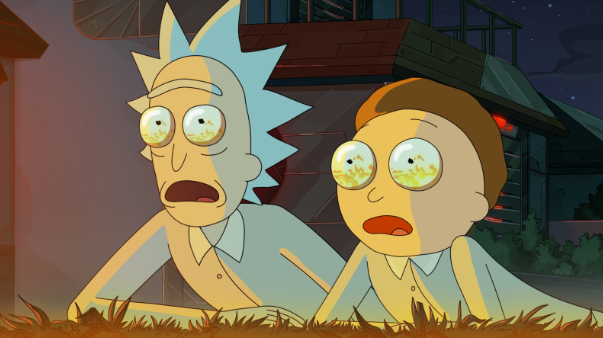

# Import necessary dependencies 

In [1]:
import pandas as pd
import nltk
import numpy as np
import re  #regular expressions
from nltk.stem import wordnet  # for lemmtization
from sklearn.feature_extraction.text import CountVectorizer  # for bag of words (bow)
from sklearn.feature_extraction.text import TfidfVectorizer  #for tfidf
from nltk import pos_tag  # for parts of speech
from sklearn.metrics import pairwise_distances  # cosine similarity
from nltk import word_tokenize
from nltk.corpus import stopwords 
nltk.download('omw-1.4')  #this is for the .apply() function to work 

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

# Choose dataset and read it into a data frame
dataset provided as csv file from here: https://www.kaggle.com/datasets/andradaolteanu/rickmorty-scripts?datasetId=506221

In [2]:
#check what files are available afer adding the database manually
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/rickmorty-scripts/RickAndMortyScripts.csv


In [3]:
df= pd.read_csv('/kaggle/input/rickmorty-scripts/RickAndMortyScripts.csv')  # read the database into a data frame
df.head()  # see first 5 lines

,index,season no.,episode no.,episode name,name,line
0,0,1,1,Pilot,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,1,1,1,Pilot,Morty,"What, Rick? What’s going on?"
2,2,1,1,Pilot,Rick,"I got a surprise for you, Morty."
3,3,1,1,Pilot,Morty,It's the middle of the night. What are you tal...
4,4,1,1,Pilot,Rick,"Come on, I got a surprise for you. Come on, h..."


In [4]:
# delete columns other than name and line
df = df.drop(columns=['index', 'season no.', 'episode no.', 'episode name'])
df.head()

,name,line
0,Rick,Morty! You gotta come on. Jus'... you gotta co...
1,Morty,"What, Rick? What’s going on?"
2,Rick,"I got a surprise for you, Morty."
3,Morty,It's the middle of the night. What are you tal...
4,Rick,"Come on, I got a surprise for you. Come on, h..."


In [5]:
# check for null values / empty cells
df.isnull().values.any()

False

No null values in this dataset. Great.

# Preprocess data

### Create function to clean our data and carry out lemmatization

In [6]:
def text_normalization(text):
    text = str(text).lower()  # convert to all lower letters
    spl_char_text = re.sub(r'[^a-z]', ' ', text)  # remove any special characters including numbers
    tokens = nltk.word_tokenize(spl_char_text)  # tokenize words
    lema = wordnet.WordNetLemmatizer()  # lemmatizer initiation
    tags_list = pos_tag(tokens, tagset = None)  # parts of speech
    lema_words = []
    for token, pos_token in tags_list:
        if pos_token.startswith('V'):  # if the tag from tag_list is a verb, assign 'v' to it's pos_val
            pos_val = 'v'
        elif pos_token.startswith('J'):  # adjective
            pos_val = 'a'
        elif pos_token.startswith('R'):  # adverb
            pos_val = 'r'
        else:  # otherwise it must be a noun
            pos_val = 'n'
        lema_token = lema.lemmatize(token, pos_val)  # performing lemmatization
        lema_words.append(lema_token)  # addid the lemmatized words into our list
    return " ".join(lema_words)  # return our list as a human sentence

In [7]:
normalized = df['line'].apply(text_normalization)
df.insert(2, 'Normalized line', normalized, True)
df.head()

,name,line,Normalized line
0,Rick,Morty! You gotta come on. Jus'... you gotta co...,morty you get ta come on jus you get ta come w...
1,Morty,"What, Rick? What’s going on?",what rick what s go on
2,Rick,"I got a surprise for you, Morty.",i get a surprise for you morty
3,Morty,It's the middle of the night. What are you tal...,it s the middle of the night what be you talk ...
4,Rick,"Come on, I got a surprise for you. Come on, h...",come on i get a surprise for you come on hurry up


### Also, create function to remove stop words from text

In [8]:
stop = stopwords.words('english')
def removeStopWords(text):
    Q = []
    s = text.split()  # create an array of words from our text sentence, cut it into words
    q = ''
    for w in s:  # for every word in the given sentence if the word is a stop word ignore it
        if w in stop:
            continue
        else:  # otherwise add it to the end of our array
            Q.append(w)
        q = " ".join(Q)  # create a sentence out of our array of non stop words
    return q

In [9]:
normalized_non_stopwords = df['Normalized line'].apply(removeStopWords)
df.insert(3, 'Normalized and StopWords Removed', normalized_non_stopwords, True)
df.head()

,name,line,Normalized line,Normalized and StopWords Removed
0,Rick,Morty! You gotta come on. Jus'... you gotta co...,morty you get ta come on jus you get ta come w...,morty get ta come jus get ta come
1,Morty,"What, Rick? What’s going on?",what rick what s go on,rick go
2,Rick,"I got a surprise for you, Morty.",i get a surprise for you morty,get surprise morty
3,Morty,It's the middle of the night. What are you tal...,it s the middle of the night what be you talk ...,middle night talk
4,Rick,"Come on, I got a surprise for you. Come on, h...",come on i get a surprise for you come on hurry up,come get surprise come hurry


# TF-IDF
### Term Frequency - Inverse Document Frequency

In [10]:
tfidf = TfidfVectorizer()  # initializing tf-idf
x_tfidf = tfidf.fit_transform(df['Normalized and StopWords Removed']).toarray()  # oversimplifying this converts words to vectors

features_tfidf = tfidf.get_feature_names_out()  # use function to get all the normalized words
df_tfidf = pd.DataFrame(x_tfidf, columns = features_tfidf)  # create dataframe to show the 0, 1 value for each word
# df_tfidf.loc[:,['hello', 'rick', 'morty']].head()  # show only specific columns
df_tfidf.head()

,aaaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhh,aaaaaaaaaaaaaaaaaaaaaaahhhhhhhhhhhhhhhh,aaaaaaaaaaahhhhh,aaaaaaaahhhh,aaaaaaahhh,aaaaaaahhhh,aaaaaah,aaaaagh,aaaaah,aaaah,...,yo,young,youtube,yup,yyyyyyyyyyou,zero,zip,zit,zone,zorpathion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create class Answer to be able to store two variables inside

In [11]:
class Answer:
  def __init__(self, name, text):
    self.name = name
    self.text = text

In [12]:
def chat(question):
    tidy_question = text_normalization(removeStopWords(question))  # clean & lemmatize the question
    tf = tfidf.transform([tidy_question]).toarray()  # convert the question into a vector
    cos = 1- pairwise_distances(df_tfidf, tf, metric = 'cosine')  # calculate the cosine value
    index_value = cos.argmax()  # find the index of the maximum cosine value
    answer = Answer(df['name'].loc[index_value + 1], df['line'].loc[index_value + 1])
    return answer

# Create function to create a chatbot experience

In [13]:
def chatbot():
    exit_chatbot = False
    first_loop = True

    while exit_chatbot == False:
        if (first_loop):
            print("Welcome to the Rick and Morty chatbot! Type q to close it, otherwise let's get schwifty \U0001F44D")
            first_loop = False
        user_input_question = input("What do you want to say:")
            
        if(user_input_question.lower() == 'q'): 
            exit_chatbot = True
            print("Byeeee!")
        else :
            answer = chat(user_input_question)
            print(answer.name + "'s answer: " + answer.text)
            

# Start the ChatBot
## Uncomment the line, run the cell and have fun

In [14]:
# chatbot()

***


**See my original ChatBot project as a reference:**

https://www.kaggle.com/code/werakaggle/chatbot-using-nltk
